# Network Analysis - Brooklyn and Staten Island Traffic Accidents

## Introdução

Esse projeto se trata de uma análise da rede viária de Brooklyn e Staten Island, dois bairros de New York, com foco em acidentes registrados de 01-Jan-2025 até dia 06-Jul-2025.

Será utilizada técnicas de análise de rede, na qual as ruas e avenidas são modeladas como um grafo direcionado, com os nós representando interseções ou pontos de interesse, e as areas representa os trechos entre um ponto e outro.

Com isso será explorada a distribuição de acidentes nas vias, a conectividade da rede, pontos críticos de acordo com algumas medidas de centralidade, etc.

In [661]:
#imports
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import requests
from PIL import Image
from io import BytesIO
import os

## Dataset

O dataset utilizado será um arquivo CSV contendo dados sobre acidentes de trânsito na cidade de New York entre dois bairros, Brookyn e Staten Island, reportados pelo departamento de polícia, enquanto os nós, arestas e geometria do mapa serão fornecidos pela OSMNX, uma biblioteca que trabalha com mapas e grafos em Python.

[Fonte do dataset](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data)

In [662]:
df = pd.read_csv("dataset/new_york_vehicle_crashes_20250706.csv")
df.head()

CRASH DATE CRASH TIME   BOROUGH  ZIP CODE  LATITUDE  LONGITUDE  \
0  2023-11-01       1:29  BROOKLYN   11230.0  40.62179 -73.970024   
1  2023-04-26      13:30       NaN       NaN       NaN        NaN   
2  2023-11-01       7:12       NaN       NaN       NaN        NaN   
3  2023-11-01       8:01       NaN       NaN       NaN        NaN   
4  2023-04-26      22:20       NaN       NaN       NaN        NaN   

                 LOCATION            ON STREET NAME   CROSS STREET NAME  \
0  (40.62179, -73.970024)             OCEAN PARKWAY            AVENUE K   
1                     NaN            WEST 54 STREET                 NaN   
2                     NaN  HUTCHINSON RIVER PARKWAY                 NaN   
3                     NaN            WEST 35 STREET  HENRY HUDSON RIVER   
4                     NaN                       NaN                 NaN   

                          OFF STREET NAME  ...  \
0                                     NaN  ...   
1                                     NaN  ...   
2                                     NaN  ...   
3                                     NaN  ...   
4  61        Ed Koch queensborough bridge  ...   

    CONTRIBUTING FACTOR VEHICLE 2  CONTRIBUTING FACTOR VEHICLE 3  \
0                     Unspecified                    Unspecified   
1                     Unspecified                            NaN   
2  Driver Inattention/Distraction                            NaN   
3                             NaN                            NaN   
4                             NaN                            NaN   

   CONTRIBUTING FACTOR VEHICLE 4  CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                            NaN                            NaN       4675373   
1                            NaN                            NaN       4623759   
2                            NaN                            NaN       4675709   
3                            NaN                            NaN       4675769   
4                            NaN                            NaN       4623865   

   VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
0                Moped                                Sedan   
1                Sedan                            Box Truck   
2                Sedan  Station Wagon/Sport Utility Vehicle   
3                Sedan                                  NaN   
4                Sedan                        Pick-up Truck   

   VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  
0                Sedan                 NaN                 NaN  
1                  NaN                 NaN                 NaN  
2                  NaN                 NaN                 NaN  
3                  NaN                 NaN                 NaN  
4                  NaN                 NaN                 NaN  

[5 rows x 29 columns]

Os dados do dataset foram filtrados para manter apenas colunas que poderiam ser de interesse, com isso foram computados 40604 acidentes em toda New York e 13646 nos bairros e ruas escolhidos a partir de 01/01/2025 até 06/07/2025, na qual possuíam as coordenadas registradas.

In [663]:
df.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [667]:
df = df[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'LATITUDE', 'LONGITUDE',
         'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME']]
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], format='%Y-%m-%d')
df = df[df['CRASH DATE'] >= '2025-01-01']
df.head()

CRASH DATE CRASH TIME BOROUGH   LATITUDE  LONGITUDE  \
113 2025-04-02       9:30  QUEENS  40.598660 -73.753006   
321 2025-04-07      12:40   BRONX  40.868706 -73.884710   
322 2025-04-07       6:00   BRONX  40.875100 -73.911710   
336 2025-01-31       8:19  QUEENS  40.720375 -73.855510   
337 2025-02-02      20:36     NaN  40.613235 -74.178610   

                   LOCATION     ON STREET NAME CROSS STREET NAME  \
113  (40.59866, -73.753006)                NaN               NaN   
321  (40.868706, -73.88471)  BEDFORD PARK BLVD        MARION AVE   
322    (40.8751, -73.91171)                NaN               NaN   
336  (40.720375, -73.85551)          EXETER ST  YELLOWSTONE BLVD   
337  (40.613235, -74.17861)                NaN               NaN   

           OFF STREET NAME  
113  327       BEACH 19 ST  
321                    NaN  
322     135       W 225 ST  
336                    NaN  
337    1120      SOUTH AVE

In [669]:
print(f'Total de acidentes presentes: {len(df)}')

Total de acidentes presentes: 41127


Algumas ruas foram inclusas, pois não estão com o bairro incluso no dataset.

> OBS: Alguns trecho pode ter passado despercebido na inclusão

In [670]:
df_with_cord = df[df['LATITUDE'].notna() & df['LONGITUDE'].notna()]

df_filtered = df_with_cord[
    df_with_cord['BOROUGH'].isin(['BROOKLYN', 'STATEN ISLAND']) |
    df_with_cord['ON STREET NAME'].str.contains(
        'BROOKLYN BRIDGE|VERRAZANO BRIDGE UPPER|QUEENSBORO BRIDGE UPPER|MANHATTAN BRIDGE|BELT PARKWAY',
        case=False,
        na=False
    )
]

df_filtered.head()

CRASH DATE CRASH TIME   BOROUGH   LATITUDE  LONGITUDE  \
386 2025-02-02      16:15  BROOKLYN  40.700726  -73.94062   
427 2025-03-20      13:30  BROOKLYN  40.630604  -74.00958   
617 2025-01-29      13:39  BROOKLYN  40.601220  -74.01013   
712 2025-01-27      22:50  BROOKLYN  40.680880  -73.98371   
925 2025-02-01      10:00  BROOKLYN  40.644630  -73.95511   

                   LOCATION ON STREET NAME CROSS STREET NAME  \
386  (40.700726, -73.94062)            NaN               NaN   
427  (40.630604, -74.00958)            NaN               NaN   
617   (40.60122, -74.01013)     SHORE PKWY         BAY 17 ST   
712   (40.68088, -73.98371)      BUTLER ST             3 AVE   
925   (40.64463, -73.95511)            NaN               NaN   

                  OFF STREET NAME  
386           16        SUMNER PL  
427  6502      FORT HAMILTON PKWY  
617                           NaN  
712                           NaN  
925         2316      BEVERLEY RD

In [671]:
print(f'Total de acidentes de com coordenadas: {len(df_filtered)}')

Total de acidentes de com coordenadas: 13646


## Manipulação da Network

### Criando um grafo utilizando OSMNX

In [672]:
place = ["Brooklyn, New York City, United States", "Staten Island, New York City, United States"]
G = ox.graph_from_place(place, network_type="drive")

cords_origin = (40.748817, -73.985428) #Cordenadas Empire State
node_origin = ox.distance.nearest_nodes(G, X=cords_origin[1], Y=cords_origin[0])

In [673]:
ox.save_graphml(G, filepath="results_brooklyn_2025/brooklyn_graph.graphml")

### Plot do grafo gerado pelo OSMNX

Esse será o grafo principal a ser analisado nesse projeto

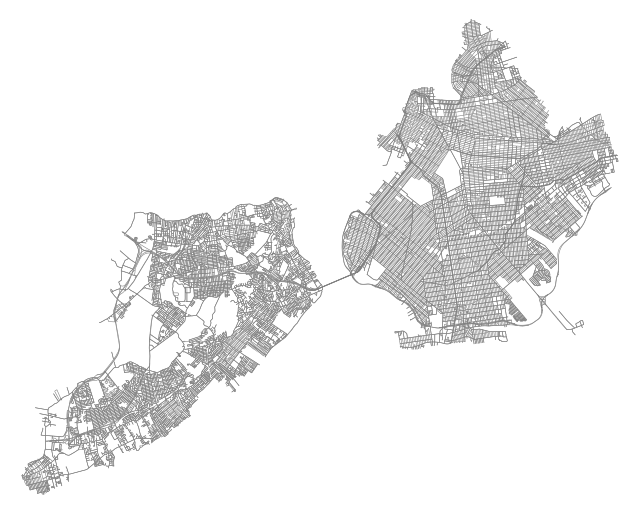

In [674]:
# plot do mapa
fig, ax = ox.plot_graph(
    G,
    show=True,
    close=True,
    bgcolor="#FFFFFF",
    edge_color="gray",
    edge_linewidth=0.4,
    filepath='results_brooklyn_2025/images/brooklyn_statenisld_map.png',
    node_size=0
)

### Quantidade de nodes e edges

- Os nós no OSMNX representam pontos de interesse na rede viária, sendo as interseções entre os trechos e pontos finais das ruas
- As arestas representam os segmentos das ruas que vão de um nó a outro, possuem o nome da rua, comprimento, etc.

In [675]:
print(f'Quantidade de nós: {len(G.nodes())}\nQuantidade de arestas: {len(G.edges())}')

Quantidade de nós: 21422
Quantidade de arestas: 53821


### Adicionando atributo de contagem de acidentes

A partir dos dados retirados do dataset, foi criado para cada nó o atributo "accident_count", na qual era adicionado a quantidade de acidentes que ocorreu em um trecho próximo àquele nó. Para isso foi utilizada as colunas de latitude e longitude.

>Essa parte do código pode demorar muito tempo

In [676]:
accident_coords = list(zip(df_filtered['LONGITUDE'], df_filtered['LATITUDE']))
accident_nodes = [ox.distance.nearest_nodes(G, x, y) for x, y in accident_coords]

for node in G.nodes:
  G.nodes[node]['accident_count'] = 0

for node in accident_nodes:
  if node in G.nodes:
    G.nodes[node]['accident_count'] += 1
    
accident_counts = [G.nodes[node]['accident_count'] for node in G.nodes]

Zerando a contagem de acidentes do nó equivocado, provavelmente houve um erro ao associar as coordenadas.

In [677]:
G.nodes[42517424]['accident_count'] = 0

In [678]:
ox.save_graphml(G, filepath="results_brooklyn_2025/brooklyn_graph_with_accidents.graphml")

In [679]:
nodes, edges = ox.graph_to_gdfs(G)

nodes.to_csv("results_brooklyn_2025/nodes.csv")
edges.to_csv("results_brooklyn_2025/edges.csv")

## Plotando o grafo/mapa

### Plot

Esse é o grafo com os acidentes destacados no nó em questão.

O bairro do Brooklyn registrou uma quantidade bem maior de acidentes, isso pode ter acontecido devido a centralidade do Brooklyn com os outros bairros de Nova York, que não estão no projeto.

C:\Users\Gusto\AppData\Local\Temp\ipykernel_23992\1898849185.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma_r')


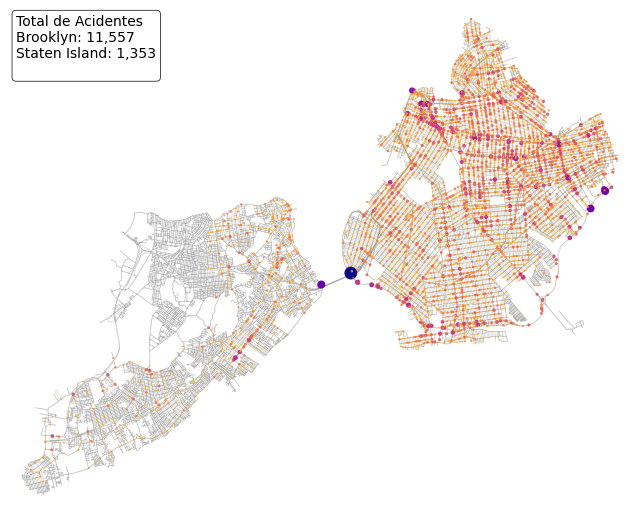

In [760]:
#Plot dos acidentes
accident_counts = [G.nodes[node].get('accident_count', 0) for node in G.nodes()]
log_counts = [np.log1p(c) for c in accident_counts]
norm = colors.Normalize(vmin=min(log_counts), vmax=max(log_counts))
cmap = cm.get_cmap('plasma_r')
log_node_colors = [cmap(norm(np.log1p(c))) for c in accident_counts]

fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    bgcolor='white',
    edge_color='gray',
    edge_alpha=0.3,
    node_color=log_node_colors,
    node_size=accident_counts,
    edge_linewidth=0.5
)

total_acidentes = df_filtered['BOROUGH'].value_counts()

legenda_texto = "Total de Acidentes\n"
for bairro, total in total_acidentes.items():
    legenda_texto += f"{bairro.title()}: {total:,}\n"

ax.text(
    0.01, 0.99,
    legenda_texto,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
)

plt.savefig('results_brooklyn_2025/images/brooklyn_statenisld_accidents_map.png', dpi=300, bbox_inches='tight')
plt.show()

In [683]:
ox.save_graphml(G, filepath="results_brooklyn_2025/brooklyn_graph_with_accidents.graphml")

## Análise das métricas do grafo

### Matriz de Ajacência

Como o grafo é gigantesco, plotar uma matriz de adjacência por completo dele seria impossível. portanto ela feita apenas um pequeno pedaço da matriz.

In [684]:
G_simple = nx.Graph(G)

adj_matrix = nx.adjacency_matrix(G_simple)

print(type(adj_matrix))
print(f"Shape: {adj_matrix.shape}")
print(f"Número de conexões reais: {adj_matrix.nnz}")

<class 'scipy.sparse._csr.csr_array'>
Shape: (21422, 21422)
Número de conexões reais: 69432


Como visto na célula anterior, o grafo é esparso, e a matriz de adjacência confirma isso apresentando a maioria dos valores como zero, isso já era previsto por ser um grafo representando um mapa real.


In [685]:
small_adj = adj_matrix[:100, :100].todense() 
adj_df_small = pd.DataFrame(small_adj)
adj_df_small

0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  96  \
0    0   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
1    1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
2    0   0   0   1   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
3    0   0   1   0   1   0   0   0   0   0  ...   0   0   0   0   0   0   0   
4    0   0   0   1   0   1   0   0   0   0  ...   0   0   0   0   0   0   0   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
95   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   1   
96   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   1   0   
97   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   1   
98   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
99   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

    97  98  99  
0    0   0   0  
1    0   0   0  
2    0   0   0  
3    0   0   0  
4    0   0   0  
..  ..  ..  ..  
95   0   0   0  
96   1   0   0  
97   0   1   0  
98   1   0   1  
99   0   1   0  

[100 rows x 100 columns]

### Diâmetro e periferia da rede


Para conseguir a maior distância da rede, é preciso de um grafo completamente conectado, e pra isso foi utilizada a maior componente conexa

In [686]:
G_cc = max(nx.connected_components(G_simple), key=len)
G_sub = G_simple.subgraph(G_cc)

#### Diâmetro

O diâmetro é a maior distancia possível (em número de nós, não confundir com quilometragem) de um nó até outro, nesse caso séria a maior distancia de um ponto a outro do mapa.


In [687]:
diameter = nx.diameter(G_sub)

In [688]:
print(f'Diâmetro da rede: {diameter}')

Diâmetro da rede: 142


Aqui foi criado uma variável de "backup" para guardar o valor do diâmetro, que já sabemos seu valor, pois é um cálculo que pode ser demorado, então caso precisemos ser rápidos, basta utilizá-la. O mesmo foi feito para a periferia em seguida

In [689]:
diameter_backup = 142
#diameter = diameter_backup

In [690]:
from networkx.algorithms.approximation import diameter as approx_diameter

ap_diameter = approx_diameter(G_sub)
print(f'Diâmetro aproximado da rede: {ap_diameter}')

Diâmetro aproximado da rede: 142


#### Periferia

A periferia são os nós que estão mais distante dos outros, no nosso caso seriam alguns pontos nos cantos do mapa.

In [691]:
periphery = nx.periphery(G_sub)

In [692]:
print(f'Nós da periferia: {periphery}')

Nós da periferia: [42475238, 1708631203, 2551248811]


In [693]:
periphery_backup = [42475238, 1708631203, 2551248811]
#periphery = periphery_backup

### Plot do diâmetro e periferia

In [767]:
G_sub = nx.MultiDiGraph(G_sub)

max_dist = 0
diameter_path = []

for u in periphery:
    for v in periphery:
        if u != v:
            try:
                path = nx.shortest_path(G_sub, u, v)
                if len(path) > max_dist:
                    max_dist = len(path)
                    diameter_path = path
            except nx.NetworkXNoPath:
                continue

G_sub_proj = ox.project_graph(G_sub)

Esse é o maior diâmetro do mapa. Ele pode parecer maior do que uma rota entre o ponto mais a sul de Staten Island e o ponto mais ao norte do Brooklyn, mas o que ele está representando, é o maior caminho possível contando os nós, não a quilometragem, então é provável que esse caminho passa por muitas interseções com outras ruas, e PROVAVELMENTE uma quantidade alta de semáforos

É notado também que esta rota passa pelos pontos com mais taxas de acidente, e por uma ponte, que provavelmente tem uma centralidade de intermediação elevada.

C:\Users\Gusto\AppData\Local\Temp\ipykernel_23992\3162414577.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma_r')


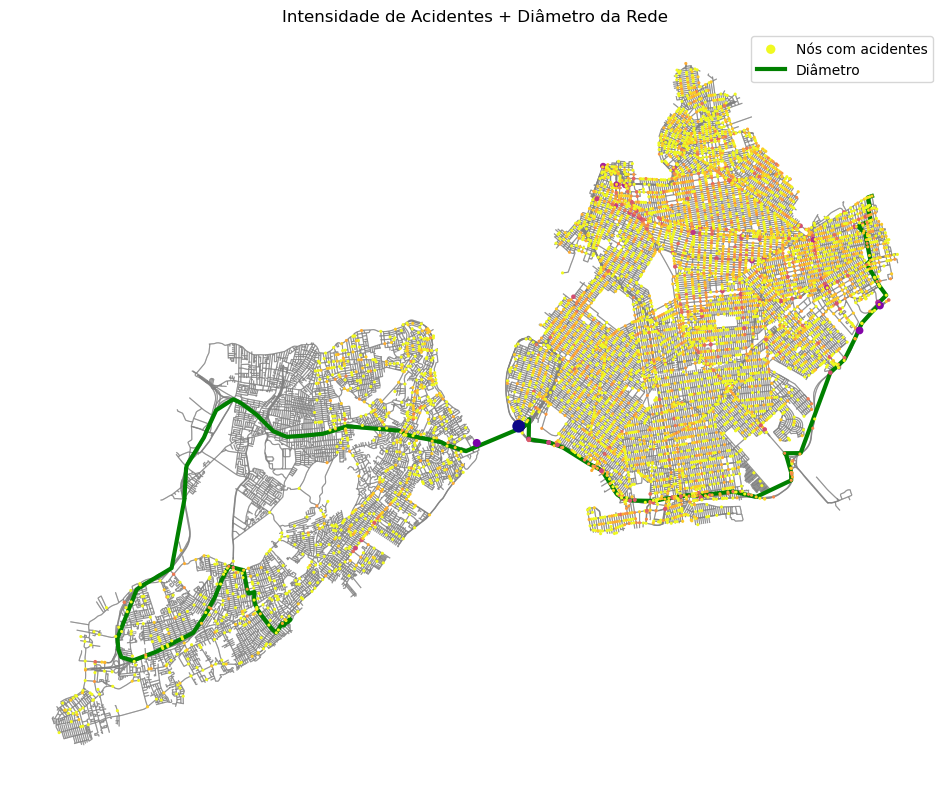

In [739]:
#Plot do diametro
nodes_with_accidents = [n for n in G_sub_proj.nodes if G_sub_proj.nodes[n].get('accident_count', 0) > 0]

accident_counts = [G_sub_proj.nodes[n]['accident_count'] for n in nodes_with_accidents]
log_counts = [np.log1p(c) for c in accident_counts]

norm = colors.Normalize(vmin=min(log_counts), vmax=max(log_counts))
cmap = cm.get_cmap('plasma_r')
log_node_colors = [cmap(norm(np.log1p(c))) for c in accident_counts]

node_x = [G_sub_proj.nodes[n]['x'] for n in nodes_with_accidents]
node_y = [G_sub_proj.nodes[n]['y'] for n in nodes_with_accidents]

x_diam = [G_sub_proj.nodes[n]['x'] for n in diameter_path]
y_diam = [G_sub_proj.nodes[n]['y'] for n in diameter_path]

edges = ox.graph_to_gdfs(G_sub_proj, nodes=False)

fig, ax = plt.subplots(figsize=(12, 12))

# ruas
edges.plot(
    ax=ax, 
    color='gray', 
    linewidth=0.8, 
    alpha=0.6
)

# nós coloridos por numero de acidentes
ax.scatter(
    node_x,
    node_y,
    c=log_node_colors,
    s=[max(5, c) for c in accident_counts],  # garante visibilidade mínima
    edgecolors='none',
    zorder=11,
    label='Nós com acidentes'
)

# caminho do diâmetro
ax.plot(
    x_diam, 
    y_diam, 
    color='green', 
    linewidth=3, 
    zorder=10, 
    label='Diâmetro'
)

plt.axis('off')
plt.legend()
plt.title('Intensidade de Acidentes + Diâmetro da Rede')
plt.savefig('results_brooklyn_2025/images/brooklyn_statenisld_accidents_diameter_map.png', dpi=300, bbox_inches='tight')
plt.show()


### Exparsidade e Densidade


- A densidade representa a quantidade de conexões em relação a todas possíveis
- A expersidade é o contrário, representa o quão nosso grafo é vazio, por isso é calculado 1 - density

Grafos urbanos tendem a ser muito esparso, já que seria impossível que todas as ruas se conectem entre si.

Como esperado, o grafo é extremamente exparso


In [698]:
density = nx.density(G_simple)
sparsity = 1 - density

print(f"Densidade da rede: {density:.6f}")
print(f"Esparsidade da rede: {sparsity:.6f}")

Densidade da rede: 0.000151
Esparsidade da rede: 0.999849


### Histograma de distribuição empírica de grau.

A distribuição empírica de grau mostra a quantidade de nós em relação ao seu grau.

Por exemplo, nesse histograma gerado, há aproximadamente 2000 nós com grau 2, em contexto com a nossa rede, isso pode significar os graus que dividem trechos de uma rua, seja uma curva ou ponto estratégico.

Foi notado uma quantidade significativa de nós apresentando grau 4 e 6, na qual podem ser cruzamentos de grandes avenidas.

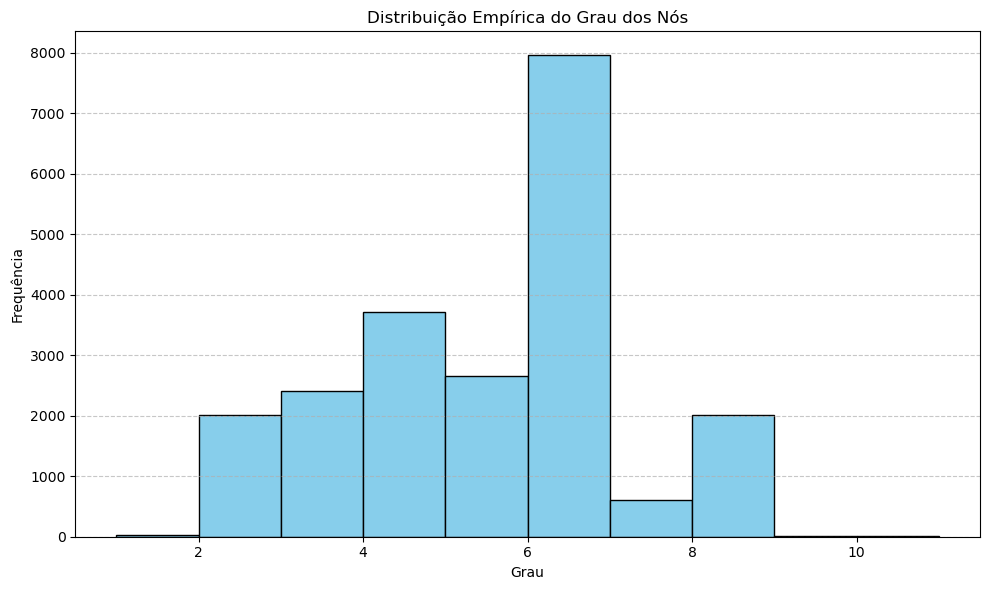

In [699]:
#Histograma

degrees = [degree for _, degree in G.degree()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(1, max(degrees)+2), edgecolor='black', color='skyblue')
plt.title("Distribuição Empírica do Grau dos Nós")
plt.xlabel("Grau")
plt.ylabel("Frequência")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results_brooklyn_2025/images/histogram_degree_nodes.png', dpi=300, bbox_inches='tight')
plt.show()

In [700]:
from collections import Counter

degree_counts = Counter(dict(G.degree()).values())
print("Quantidades exatas dos graus:", degree_counts.most_common(10))

Quantidades exatas dos graus: [(6, 7957), (4, 3712), (5, 2658), (3, 2409), (2, 2019), (8, 2004), (7, 609), (1, 36), (9, 14), (10, 4)]


 ### Coeficiente de clustering

 O coeficiente de clustering é a medida que indica o quanto os vizinhos de um nó estão conectados com os outros vizinhos do mesmo, formando um triângulo. No coeficiente de clustering global, acontece a média entre todos os coeficientes locais.
 
 No caso dessa análise, se tratando de um mapa, é bem dificil para as ruas formarem triângulos, portanto, no geral o coeficiente de clustering será bem baixo para a maioria dos nós, além do coeficiente global também ser bem baixo.

#### Coeficiente local

 Para o coeficiente de clustering local foram escolhidos os nós com maiores taxas de acidentes de grau 4 a 6, além do nó com maior taxa de acidentes no geral.

In [773]:
G_sub = nx.Graph(G)

In [805]:
# nó com maior taxa de acidente
node_most_accidents = max(G_sub.nodes, key=lambda n: G_sub.nodes[n].get('accident_count', 0))

# nó de grau 2 com maior taxa de acidente
nodes_grau_2 = [n for n, d in G_sub.degree() if d == 2]
node_degree_2 = max(nodes_grau_2, key=lambda n: G_sub.nodes[n].get('accident_count', 0)) if nodes_grau_2 else None

# nó de grau 3 com maior taxa de acidente
nodes_grau_3 = [n for n, d in G_sub.degree() if d == 3]
node_degree_3 = max(nodes_grau_3, key=lambda n: G_sub.nodes[n].get('accident_count', 0)) if nodes_grau_3 else None

# nó de grau 4 com maior taxa de acidente
nodes_grau_4 = [n for n, d in G_sub.degree() if d == 4]
node_degree_4 = max(nodes_grau_4, key=lambda n: G_sub.nodes[n].get('accident_count', 0)) if nodes_grau_4 else None

# nó de grau 5 com maior taxa de acidente
nodes_grau_5 = [n for n, d in G_sub.degree() if d == 5]
node_degree_5 = max(nodes_grau_5, key=lambda n: G_sub.nodes[n].get('accident_count', 0)) if nodes_grau_5 else None

# nó de grau 6 com maior taxa de acidente
nodes_grau_6 = [n for n, d in G_sub.degree() if d == 6]
node_degree_6 = max(nodes_grau_6, key=lambda n: G_sub.nodes[n].get('accident_count', 0)) if nodes_grau_6 else None

In [806]:
selected_nodes = [
    ("Grau 2", node_degree_2),
    ("Grau 3", node_degree_3),
    ("Grau 4", node_degree_4),
    ("Grau 5", node_degree_5),
    ("Grau 6", node_degree_6),
    ("Mais acidentes", node_most_accidents)
]

Como previsto, o coeficiente de clustering foi bem baixo globalmente e para todos os nós escolhidos, além de ter sido 0 para alguns, isto é, não há nenhum triangulo formado entre as ruas que ele conecta.

Na célula seguinte, está mostrando os nós, as ruas, a quantidade de acidentes e o coeficiente de clustering

In [807]:
for label, node in selected_nodes:
    if node is not None:
        clust = nx.clustering(G_sub, node)
        acc = G_sub.nodes[node].get('accident_count', 0)
        degree = G_sub.degree[node]

        # Coletar todas as ruas conectadas ao nó
        edges = list(G_sub.edges(node, data=True))
        street_names = set()

        for u, v, data in edges:
            name = data.get('name')
            if name:
                if isinstance(name, list):
                    street_names.update(name)
                else:
                    street_names.add(name)

        if not street_names:
            street_names_display = "(sem nome disponível)"
        else:
            street_names_display = ", ".join(sorted(street_names))

        print(f"{label}: nó {node} — ruas=({street_names_display}), grau={degree}, acidentes={acc}, clustering={clust:.4f}")
    else:
        print(f"{label}: Nenhum nó encontrado com esse grau.")

Grau 2: nó 42487242 — ruas=(East 102nd Street, Shore Parkway Service Road), grau=2, acidentes=8, clustering=0.0000
Grau 3: nó 448096469 — ruas=(Belt Parkway), grau=3, acidentes=85, clustering=0.0000
Grau 4: nó 452382143 — ruas=(Pennsylvania Avenue), grau=4, acidentes=31, clustering=0.1667
Grau 5: nó 42505482 — ruas=(Broadway, Jefferson Street, Myrtle Avenue), grau=5, acidentes=11, clustering=0.0000
Grau 6: nó 42482215 — ruas=(Flushing Avenue, Gerry Street, Marcy Avenue, Union Avenue), grau=6, acidentes=6, clustering=0.1333
Mais acidentes: nó 448096469 — ruas=(Belt Parkway), grau=3, acidentes=85, clustering=0.0000


#### Coeficiente global

In [803]:
global_clust = nx.average_clustering(G_sub)
print(f"Coeficiente de clustering global: {global_clust:.4f}")

Coeficiente de clustering global: 0.0342


#### Plot dos nós escolhidos

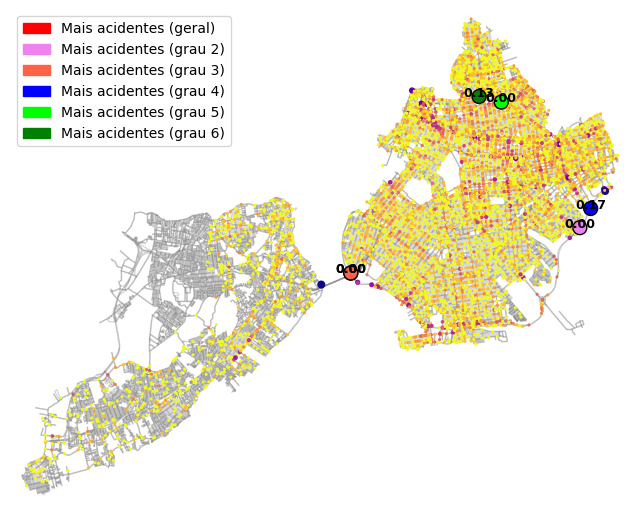

In [804]:
# plot coeficiente de clustering de nós escolhidos
clustering_dict = nx.clustering(G_sub)

highlight_nodes = [node_degree_2, node_degree_3, node_degree_4, node_degree_5, node_degree_6, node_most_accidents]
highlight_colors = {
    node_most_accidents: 'red',
    node_degree_2: 'violet',
    node_degree_3: 'tomato',
    node_degree_4: 'blue',
    node_degree_5: 'lime',
    node_degree_6: 'green'
}

# separar nós normais com acidentes
normal_nodes = [n for n in G.nodes if G.nodes[n].get('accident_count', 0) > 0 and n not in highlight_nodes]
accident_counts = [G.nodes[n]['accident_count'] for n in normal_nodes]
log_counts = [np.log1p(c) for c in accident_counts]

# cores norm
norm = colors.Normalize(vmin=min(log_counts), vmax=max(log_counts))
cmap = plt.colormaps.get_cmap('plasma_r')

# plot
fig, ax = ox.plot_graph(
    G,
    node_color='none',
    edge_color='gray',
    edge_alpha=0.3,
    bgcolor='white',
    show=False,
    close=False
)

# nós com acidentes
ax.scatter(
    [G.nodes[n]['x'] for n in normal_nodes],
    [G.nodes[n]['y'] for n in normal_nodes],
    s=[max(5, c) for c in accident_counts],
    c=[cmap(norm(np.log1p(G.nodes[n]['accident_count']))) for n in normal_nodes],
    edgecolors='none',
    zorder=2
)

# nós destacados
ax.scatter(
    [G.nodes[n]['x'] for n in highlight_nodes],
    [G.nodes[n]['y'] for n in highlight_nodes],
    s=[100 for _ in highlight_nodes],
    c=[highlight_colors[n] for n in highlight_nodes],
    edgecolors='black',
    linewidths=1,
    zorder=3
)

# coeficiente de clustering
for node in highlight_nodes:
    x = G.nodes[node]['x']
    y = G.nodes[node]['y']
    ccoef = clustering_dict[node]
    ax.text(
        x, y + 0.0002,
        f"{ccoef:.2f}",
        fontsize=9,
        fontweight='bold',
        color='black',
        ha='center',
        zorder=4
    )

legend_patches = [
    mpatches.Patch(color='red', label=f'Mais acidentes (geral)'),
    mpatches.Patch(color='violet', label=f'Mais acidentes (grau 2)'),
    mpatches.Patch(color='tomato', label=f'Mais acidentes (grau 3)'),
    mpatches.Patch(color='blue', label=f'Mais acidentes (grau 4)'),
    mpatches.Patch(color='lime', label=f'Mais acidentes (grau 5)'),
    mpatches.Patch(color='green', label=f'Mais acidentes (grau 6)')
]
ax.legend(handles=legend_patches, loc='upper left')

plt.savefig('results_brooklyn_2025/images/coef_clustering_map.png', dpi=300, bbox_inches='tight')
plt.show()


### Componentes Conectados

Um componente fortemente conectado é um subgrafo de uma rede na qual os nós se conectam com todos, essa métrica funciona apenas para nós direcionados, um nó fracamente conectado ignora a direção.

No nosso contexto, na qual utilizamos um mapa, é muito provável que ele seja muito bem conectado fortemente, com poucos nós ficando de fora, pois eles representariam uma rua de mão única, nesse caso esses nós representando ruas de apenas um sentido estariam presentes no componente fracamente conectado

#### Componetes fortemente conectados

In [707]:
scc = list(nx.strongly_connected_components(G))

print(f"Total de componentes fortemente conectados: {len(scc)}")
print(f"Tamanho da maior SCC: {len(max(scc, key=len))}")


Total de componentes fortemente conectados: 96
Tamanho da maior SCC: 21323


#### Componetes fracamente conectados

In [708]:
wcc = list(nx.weakly_connected_components(G))

print(f"Total de componentes fracamente conectados: {len(wcc)}")
print(f"Tamanho da maior WCC: {len(max(wcc, key=len))}")

Total de componentes fracamente conectados: 1
Tamanho da maior WCC: 21422


Como previsto, o maior componente fracamente conectado possui uma quantidade um pouco maior de nós do que o maior fortemente conectado. Não é muito mas esses nós podem indicar vias de mão única.

A seguir, o plot do maior SCC sobre o maior WCC

#### Plot

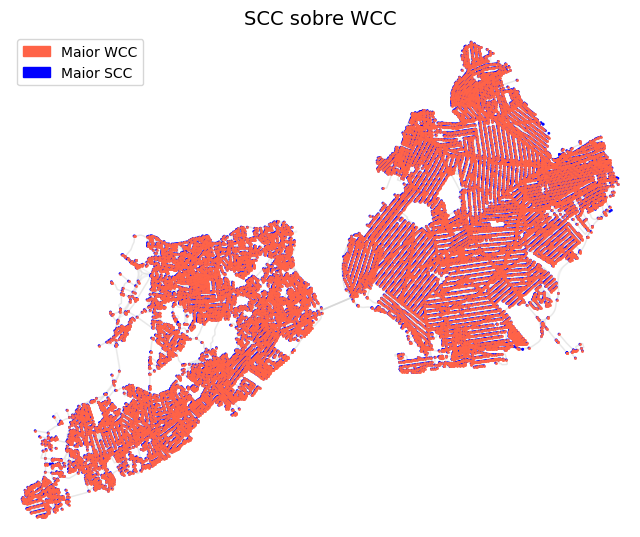

In [709]:
#scc x wcc
# maior scc
largest_scc = max(nx.strongly_connected_components(G), key=len)
G_strong = G.subgraph(largest_scc).copy()

# maior wcc
largest_wcc = max(nx.weakly_connected_components(G), key=len)
G_weak = G.subgraph(largest_wcc).copy()

# plot do maior wcc
fig, ax = ox.plot_graph(
    G_weak,
    node_color='blue',
    node_size=4,
    edge_color='lightgray',
    edge_alpha=0.3,
    bgcolor='white',
    show=False,
    close=False,
)

# plot do maior wcc
node_xs = [G_strong.nodes[n]['x'] for n in G_strong.nodes]
node_ys = [G_strong.nodes[n]['y'] for n in G_strong.nodes]
ax.scatter(node_xs, node_ys, c='tomato', s=1, zorder=10)

legend_patches = [
    mpatches.Patch(color='tomato', label=f'Maior WCC'),
    mpatches.Patch(color='blue', label=f'Maior SCC')
]
ax.legend(handles=legend_patches, loc='upper left')

plt.title("SCC sobre WCC", fontsize=14)
plt.savefig('results_brooklyn_2025/images/scc_wcc_map.png', dpi=300, bbox_inches='tight')
plt.show()


### Medidas de Centralidade

Agora serão mostradas 4 medidas de centralidade: Eingenvector, Degree, Closeness e Betweenness. Em seguida será mostrado o top 5 nós para cada centralidade e suas posições no mapa, acompanhados de uma discussão sobre eles.

In [710]:
G_central = G_sub.to_undirected() if G.is_directed() else G

- Eigenvector Centrality 

Representa o quão importante um nó é em relação com seus vizinhos também serem importantes.

Em um mapa, um nó com a eigenvector centrality alta indica um nó que provavelmente está no centro de uma cidade, já que ao seu redor haverá mais nós importantes.

In [711]:
eigen = nx.eigenvector_centrality(G_central, max_iter=1000)

- Degree Centrality 

Representa quantos vizinhos imediados um nó tem.

Em uma cidade esse valor pode indicar grandes cruzamentos

In [712]:
degree = nx.degree_centrality(G)

- Closeness Centrality 

Representa o quão próximo um nó está em relação a todo o grafo, ou seja, possui a menor distância mínima média entre todos os nós.

Em uma cidade, representa um nó central na qual levaria o menor tempo médio para ir para qualquer lugar do mapa, porém há um viés nisso, essa distância média não é representada em medida de distância real, mas sim em nós. Porém, os nós representam, na maioria das vezes, encontro entre ruas, podendo haver semáforos. Entretando isso depende do lugar a ser estudado e cabe uma análise mais aprofundada.

In [713]:
closeness = nx.closeness_centrality(G)

- Betweenness Centrality 

Indica a frequencia que um nó aparece no caminho mais curto entre outros dois nós. Isso é, determina se o nó é uma ponte ou não.

No contexto de uma cidade, esse nó poderia ser identificado como pontes atravessando rios, ou caminhos únicos ligando alguma cidade. Esses nós são muito importantes para uma rede viária, já que, por ser um caminho único, pode haver congestionamento no local. Além disso, caso uma ponte caia, ou tal caminho seja interditado, um local pode ficar completa ou parcialmente isolado de outro.

In [714]:
betweenness = nx.betweenness_centrality(G)

In [715]:
df_centrality = pd.DataFrame({
    "eigenvector": pd.Series(eigen),
    "degree": pd.Series(degree),
    "closeness": pd.Series(closeness),
    "betweenness": pd.Series(betweenness),
})

In [716]:
df_centrality["accidents"] = df_centrality.index.map(lambda n: G.nodes[n].get('accident_count', 0))
df_centrality["degree_raw"] = pd.Series(dict(G.degree()))

In [717]:
def get_street_names(G, node):
    edges = G.edges(node, data=True)
    names = set()
    for _, _, data in edges:
        name = data.get('name')
        if isinstance(name, list):
            names.update(name)
        elif isinstance(name, str):
            names.add(name)
    return ', '.join(names) if names else "Rua desconhecida"

#### Tabela dos top 5 nós para cada centralidade

Eis os 5 nós com maior centralidade de cada tipo. Mais a frente eles terão suas posições plotadas no mapa para uma melhor visualização.

In [809]:
#Tabela de centralidades
for measure in ["eigenvector", "degree", "closeness", "betweenness"]:
    print(f"\nTop 5 nós por {measure.capitalize()} Centrality:\n")
    print(f"{'Rua':<50} | {measure.capitalize():<12} | {'Acidentes':<9} | {'Coordenadas':<25}")
    print("-" * 120)

    top5 = df_centrality.sort_values(by=measure, ascending=False).head(5)

    for node_id, row in top5.iterrows():
        street_name = get_street_names(G_central, node_id)
        street_name = street_name[:47] + "..." if len(street_name) > 50 else street_name

        if measure == "degree":
            valor_centralidade = row["degree_raw"]
        else:
            valor_centralidade = f"{row[measure]:.5f}"

        x = G_central.nodes[node_id]['x']
        y = G_central.nodes[node_id]['y']
        coords = f"({y:.6f}, {x:.6f})"

        print(f"{street_name:<50} | {valor_centralidade:<12} | {row['accidents']:<9} | {coords:<25}")


Top 5 nós por Eigenvector Centrality:

Rua                                                | Eigenvector  | Acidentes | Coordenadas              
------------------------------------------------------------------------------------------------------------------------
Kings Highway, East 35th Street, Avenue M          | 0.32385      | 4.0       | (40.620153, -73.940809)  
Kings Highway                                      | 0.27749      | 0.0       | (40.619592, -73.941328)  
Kings Highway, East 34th Street                    | 0.25752      | 0.0       | (40.619765, -73.941620)  
New York Avenue, Kings Highway                     | 0.24363      | 1.0       | (40.618593, -73.942416)  
Kings Highway, East 36th Street                    | 0.23792      | 0.0       | (40.621164, -73.939991)  

Top 5 nós por Degree Centrality:

Rua                                                | Degree       | Acidentes | Coordenadas              
--------------------------------------------------------------

##### Funções de auxílio

In [719]:
def montar_legenda(G, node, centralidade_nome, centralidade_valor, num_saltos=2):
    ruas = get_street_names(G, node)

    nos_proximos = set([node])
    fronteira = set([node])
    for _ in range(num_saltos):
        vizinhos = set()
        for n in fronteira:
            vizinhos.update(G.neighbors(n))
        vizinhos = vizinhos - nos_proximos
        nos_proximos.update(vizinhos)
        fronteira = vizinhos

    acc_proximos = sum(G.nodes[n].get('accident_count', 0) for n in nos_proximos)

    if centralidade_nome.lower() == "degree":
        return (f"{centralidade_nome}:\n{ruas}\n"
                f"Acidentes próximos (até {num_saltos} saltos): {acc_proximos}\n"
                f"{centralidade_nome}: {G.degree[node]}")
    else:
        return (f"{centralidade_nome}:\n{ruas}\n"
                f"Acidentes próximos (até {num_saltos} saltos): {acc_proximos}\n"
                f"{centralidade_nome}: {centralidade_valor:.4f}")

In [720]:
def plot_top_centrality_nodes(G, df_centrality, centralidade, top_n=5, num_saltos=2):
    
    top_nodes = df_centrality.sort_values(by=centralidade, ascending=False).head(top_n).index.tolist()
    valores = df_centrality.loc[top_nodes, centralidade].values

    norm = mcolors.Normalize(vmin=valores.min(), vmax=valores.max())

    def darken_norm(x): return 0.6 + 0.4 * x  # faixa escura do colormap
    norm2 = lambda x: darken_norm(norm(x))
    cmap = plt.cm.Reds

    node_list = list(G.nodes)
    node_idx = {node: i for i, node in enumerate(node_list)}
    node_colors = ['lightgray'] * len(node_list)
    node_sizes = [1] * len(node_list)
    legendas = []

    for node in top_nodes:
        idx = node_idx[node]
        val = df_centrality.loc[node, centralidade]
        cor = cmap(norm2(val))
        node_colors[idx] = cor
        node_sizes[idx] = 150 

        texto_legenda = montar_legenda(G, node, centralidade.capitalize(), val, num_saltos)
        cor_hex = mcolors.to_hex(cor)
        legendas.append((cor_hex, texto_legenda))

    # plot
    fig, ax = ox.plot_graph(
        G,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='lightgray',
        edge_alpha=0.4,
        bgcolor='white',
        show=False,
        close=False
    )

    handles = [
        Line2D([0], [0], marker='o', color='w', label=texto,
               markerfacecolor=cor, markersize=10)
        for cor, texto in legendas
    ]

    plt.legend(handles=handles, loc='upper left', fontsize=8, frameon=True)
    plt.title(f"Top {top_n} - {centralidade.capitalize()} Centrality")
    plt.tight_layout()
    plt.savefig(f"results_brooklyn_2025/images/top_nodes_{centralidade.lower()}.png", dpi=300)
    plt.show()


In [790]:
def plot_img(path_or_url):
    try:
        if path_or_url.startswith('http://') or path_or_url.startswith('https://'):
            response = requests.get(path_or_url)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
        else:
            if not os.path.exists(path_or_url):
                raise FileNotFoundError(f"Arquivo não encontrado: {path_or_url}")
            img = Image.open(path_or_url)

        plt.imshow(img)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Erro ao carregar a imagem: {e}")

#### Eigenvector Centrality Plot

Os nós com maior Eigenvector Centrality ficaram muito juntos, isso já era previsto, já que, como discutido antes, esses nós representariam centros importantes de uma cidade.

Nesse grafo, os maiores eigen. cent caíram na Kings Highway, de fato é uma avenida importante para Brooklyn, predominantemente residencial.

Próximo aos pontos não houve uma quantidade significativa de acidentes, mesmo sendo uma área importante para o Eingenvector. Uma ideia seria reavaliar o valor de Eigenvector do Brooklyn considerando toda Nova York, porém, nesse projeto não seria viável por gastar muito tempo de processamento de dados. (houve tentativas)

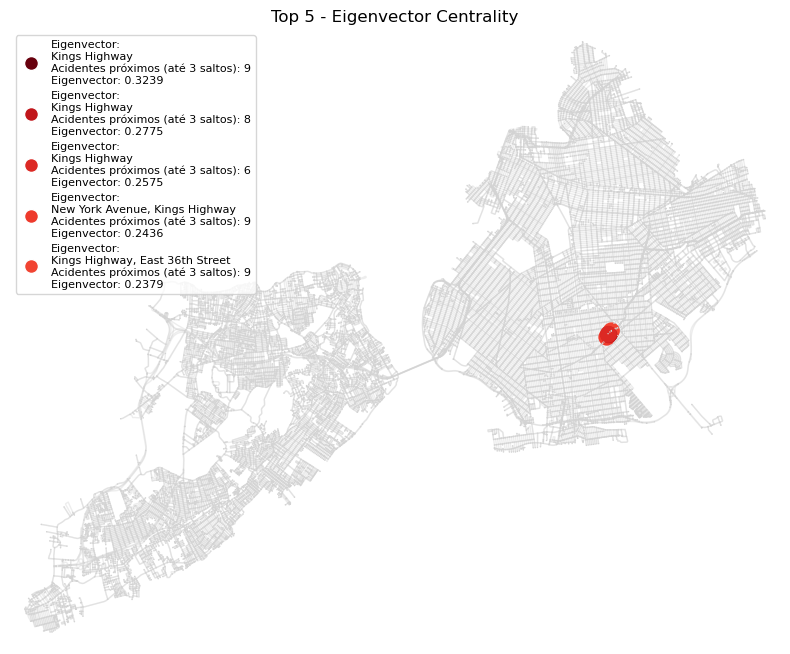

In [722]:
plot_top_centrality_nodes(G, df_centrality, 'eigenvector', top_n=5, num_saltos=3)

##### Foto da Kings Highway

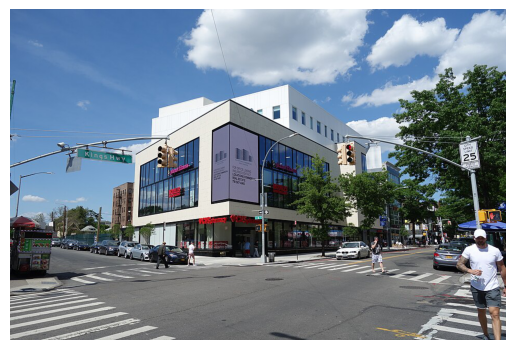

In [723]:
plot_img("https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Kings_Hwy_E_16th_St_td_%282019-05-27%29_03_-_1601_Kings_Highway.jpg/960px-Kings_Hwy_E_16th_St_td_%282019-05-27%29_03_-_1601_Kings_Highway.jpg?20200707025525")

#### Betweenness Centrality Plot

Os nós com maior Betweenness Centraly caíram basicamente em uma rota da Gowanus Expressway, atravessando a Ponte Verrazzano-Narrows e chegando em outra expressway, sendo essa da Staten Island.

De fato, a Gowanus Expressway, uma via expressa suspensa, que liga dois bairros e possui poucos pontos de acesso, merece um dos maiores betweenness.

Quando olha o mapa por cima, é comum achar que o nó com maior valor irá cair exatamente na ponte, já que é exatamente isso que ele mede, porém no mapa, essa grande ponte ligando a ilha com Brooklyn "continua" com a Gowanus, possuíndo poucas saídas. Então caso a Gowanus fique 100% interditada, haverá problemas sérios no trânsito.

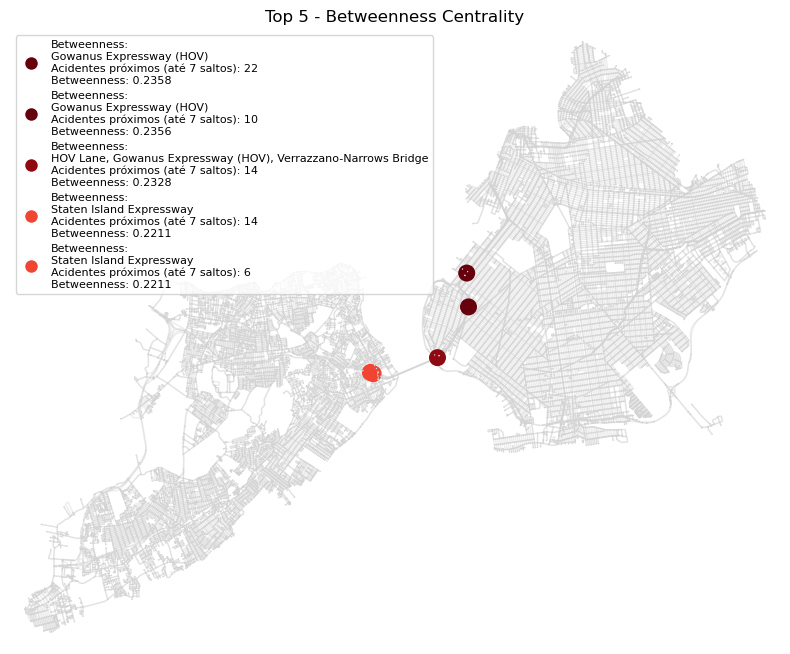

In [724]:
plot_top_centrality_nodes(G, df_centrality, 'betweenness', top_n=5, num_saltos=7)

##### Foto da Gowanus Espressway Plot

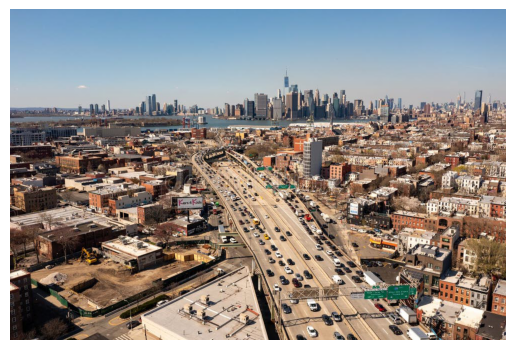

In [725]:
plot_img('https://thumbs.dreamstime.com/b/gowanus-neighborhood-brooklyn-new-york-apr-panoramic-view-expressway-218635342.jpg?w=992')

#### Degree Centrality

Como esperado, os maiores graus deram em cruzamentos com várias ruas, porém se analizar cada coordenada, veremos que não há 10 ruas ou algo parecido com isso conectando ao nó, mas há muitos pequenos ligamentos próximos a ele. Provavelmente o OSMNX considerou essas pequenas vias ao juntar as arestas. 

Mas ainda assim, pode-se considerar um local de vários encontros de ruas e avenidas. E isso pode explicar a quantidade elevada de acidenres, principalmente no encontro da Avenue X com a Shell 86th Street, abaixo do viaduto, um lugar a primeira vista caótico para o trânsito.

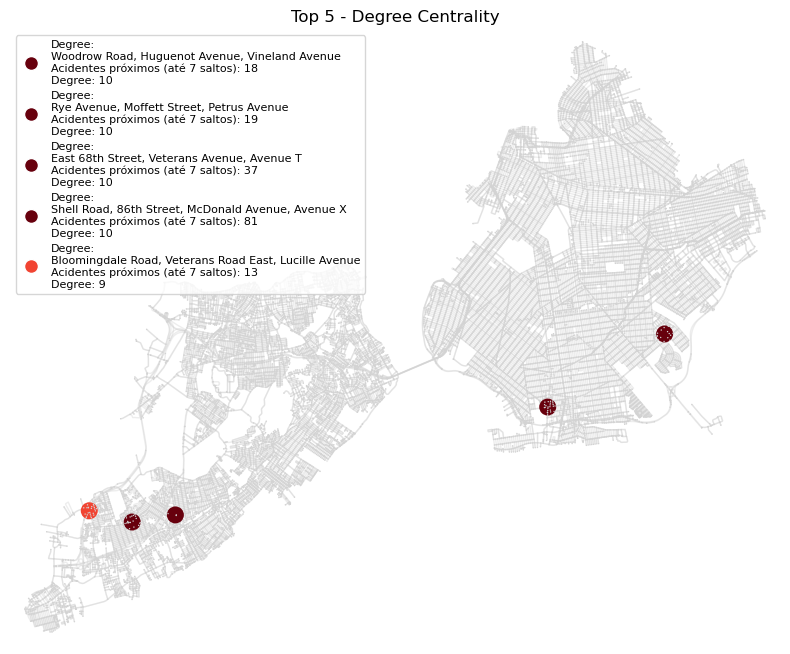

In [726]:
plot_top_centrality_nodes(G, df_centrality, 'degree', top_n=5, num_saltos=7)

##### Foto do cruzamento da Avenue X com outras ruas

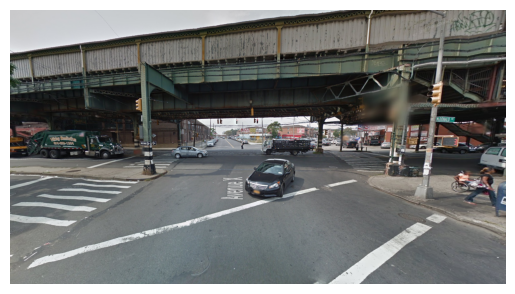

In [727]:
plot_img("dataset/avenue_x_east68th.png")

#### Closeness Centrality

Era esperado que os valores de closeness iriam cair em lugares bem no centro do mapa, já que teoricamente um nó bem no centro é mais próximo aos nós dos cantos. 

Com isso o nó de maior closeness centrality caiu na ponte que divide os dois bairros, a ponte Verrazzano-Narrows, e os outros valores foram as estradas que chegam até ela, a Gowanus Expressway, já mencionada anteriormente, e a Staten Island Expressway.

Os acidentes foram menor do que o esperado, visto que, nos mapas explorados anteriormente, tinha uma grande concentração de acidentes na área dessa ponte.

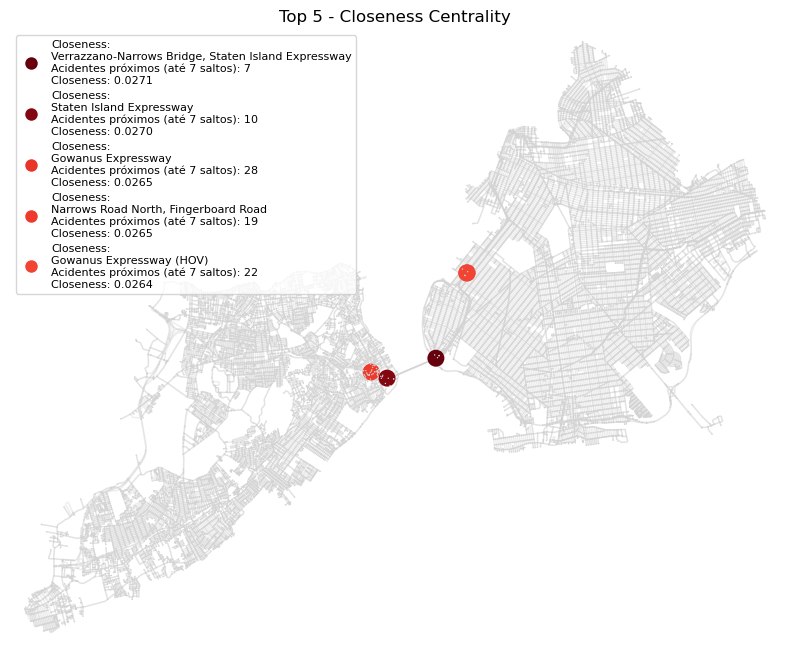

In [728]:
plot_top_centrality_nodes(G, df_centrality, 'closeness', top_n=5, num_saltos=7)

##### Foto da Ponte Verrazzano-Narrows

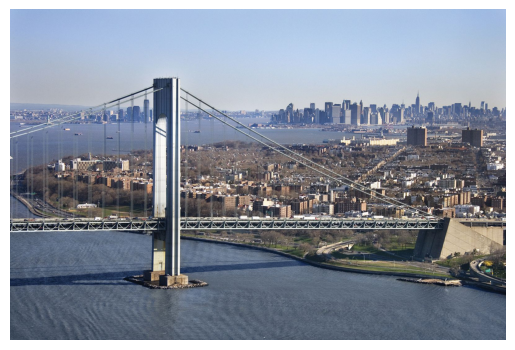

In [729]:
plot_img("https://cdn.britannica.com/17/116017-050-19B97692/Brooklyn-side-NY-Verrazzano-Narrows-Bridge.jpg")

In [ ]:
#dicionarios
max_nodes = {
    'Degree': df_centrality['degree'].idxmax(),
    'Betweenness': df_centrality['betweenness'].idxmax(),
    'Closeness': df_centrality['closeness'].idxmax(),
    'Eigenvector': df_centrality['eigenvector'].idxmax(),
}

colunas_centralidade = {
    'Degree': 'degree',
    'Betweenness': 'betweenness',
    'Closeness': 'closeness',
    'Eigenvector': 'eigenvector'
}

centralidade_cores = {
    'Degree': 'red',
    'Betweenness': 'blue',
    'Closeness': 'green',
    'Eigenvector': 'orange'
}

#### Maiores centralidades

Como foi visto, os nós com maiores centralidades são nós pertencentes ao bairro do Brooklyn, bairro esse que apresentou a esmagadora maioria dos acidentes entre os dois bairros, o nó que apresentou a maior taxa de acidentes ao seu redor foi o com maior grau, sendo ele um grau com diversas ruas conectadas.

Além disso um nó com uma taxa de 85 acidentes ocorreu próximo a ponte Verrazzano-Narrows, porém a associação do nó com o OSMNX pode ter sido errônea, tendo em vista que esse nó representa uma ponte, e a ferramenta pode ter associado este nó com um nó abaixo da ponte, e por isso, mesmo utilizando 7 saltos para identificar os acidentes, não foi apresentado um valor considerável. Porém cabe uma análise mais detalhada para identificar essa disparidade entre os nós.

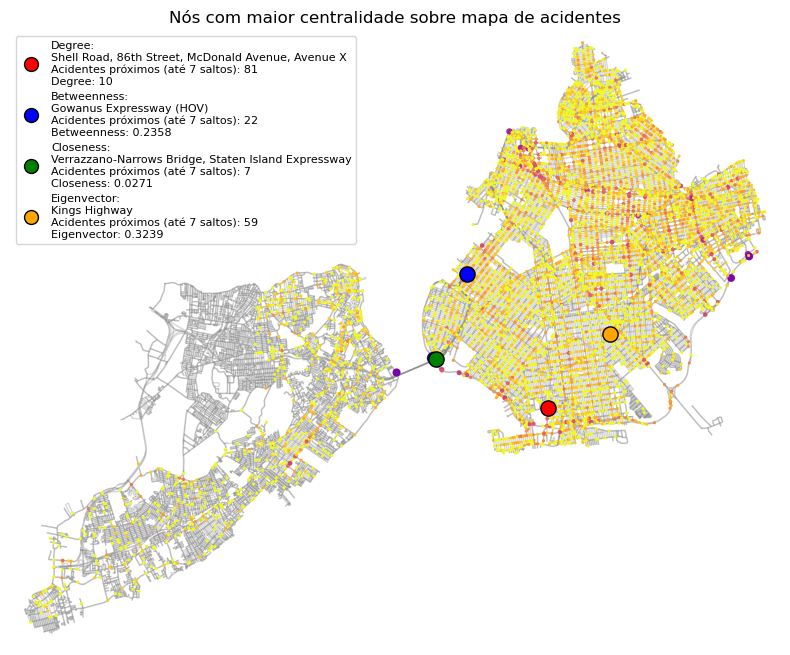

In [795]:
# Centralidades com acidentes
nodes_com_acidente = [n for n in G.nodes if G.nodes[n].get('accident_count', 0) > 0 and n not in max_nodes.values()]
accident_counts = [G.nodes[n]['accident_count'] for n in nodes_com_acidente]
log_counts = [np.log1p(c) for c in accident_counts]

norm = colors.Normalize(vmin=min(log_counts), vmax=max(log_counts))
cmap = plt.colormaps.get_cmap('plasma_r')


fig, ax = ox.plot_graph(
    G,
    node_color='none',
    edge_color='gray',
    edge_alpha=0.3,
    bgcolor='white',
    show=False,
    close=False
)

ax.scatter(
    [G.nodes[n]['x'] for n in nodes_com_acidente],
    [G.nodes[n]['y'] for n in nodes_com_acidente],
    s=[max(5, c) for c in accident_counts],
    c=[cmap(norm(np.log1p(G.nodes[n]['accident_count']))) for n in nodes_com_acidente],
    edgecolors='none',
    zorder=2
)

legendas = []
for nome, node in max_nodes.items():
    cor = centralidade_cores[nome]
    valor = df_centrality.loc[node, colunas_centralidade[nome]]
    texto_legenda = montar_legenda(G, node, nome, valor, num_saltos=7)

    ax.scatter(
        G.nodes[node]['x'],
        G.nodes[node]['y'],
        s=120,
        c=cor,
        edgecolors='black',
        linewidths=1,
        zorder=3
    )
    legendas.append((cor, texto_legenda))

handles = [
    Line2D([0], [0], marker='o', color='w', label=texto,
           markerfacecolor=cor, markeredgecolor='black', markeredgewidth=1, markersize=10)
    for cor, texto in legendas
]

ax.legend(handles=handles, loc='upper left', fontsize=8, frameon=True)
plt.title("Nós com maior centralidade sobre mapa de acidentes")

plt.tight_layout()
plt.savefig('results_brooklyn_2025/images/centralities_with_accidents.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusão

Esse projeto utilizou técnicas de análise de redes, com dados geográficos, para analisar a distribuição de acidentes em Brooklyn e Staten Island em relação a diversas métricas. Com a biblioteca OSMNX foi possível mapear esses dados utilizando o grafo viário da rede e identificar os locais em questão. Utilizando as métricas foi possível visualizar os nós possivelmente críticos e relacioná-los com a quantidade de acidentes. Uma análise como essa é útil para a segurança no trânsito, planejamento urbano, rotas estratégicas para algum tipo de transporte, etc.

Essa análise teria um maior potencial caso fosse analisado todos os bairros de Nova York, e para ser mais preciso ainda, seria interessante utilizar as cidades vizinhas para uma maior precisão, porém seria necessário um poder computacinal melhor e mais tempo, já que o grafo seria várias vezes maior.